For my project on plant disease detection, I utilized a dataset that I sourced from Kaggle. This dataset is specifically designed for identifying various plant diseases through image analysis. It consists of numerous images of plant leaves, each carefully categorized by plant pathology experts. These images represent a range of conditions – from healthy leaves to those affected by various diseases.

The original compilation of this dataset likely involved collaborations with agricultural research institutes or botanists. The process would have entailed a meticulous collection and categorization of leaf images, ensuring accurate representation of each disease type. To ensure consistency in the dataset, the images were standardized in terms of size, resolution, and orientation, focusing the model training on the disease features rather than variations in image presentation.

To prepare the dataset for machine learning applications, I divided into training and testing sets. This division is crucial as it allows the model to learn from one subset of data (the training set) and validates its performance against another (the testing set). The dataset was organized into a structured format, with separate folders for each disease type within both the training and testing directories. This organization facilitates the use of automated data loaders and generators in the model training process, which can label the images based on their folder names.

A significant aspect of preparing this dataset was offline augmentation. Augmentation is a method used to increase the diversity of the training dataset without the need for additional data collection. It involves applying various transformations to the original images, such as rotation, flipping, zooming, and adjusting brightness or contrast. These manipulations help the model to learn from a wider range of image variations, making it more robust and capable of generalizing from the training data to new, unseen data. In offline augmentation, these transformed images are saved as separate files, effectively enlarging the training dataset. The augmented images are stored alongside the original images within the respective class folders, enriching the dataset with a more diverse set of examples for each disease category.

The use of this enriched and meticulously prepared dataset from Kaggle has been instrumental in the development of a robust model for plant disease detection. The comprehensive nature of the dataset, coupled with the enhancements brought about by offline augmentation, has significantly contributed to the accuracy and reliability of the disease detection model in my project.

In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import MinMaxScaler

# Set the base path for the dataset
base_dataset_path = r"C:\Users\Hp\Downloads\plantvillage dataset"

# Define the paths for the training and testing datasets
main_train_dir = os.path.join(base_dataset_path, 'train')
main_test_dir = os.path.join(base_dataset_path, 'test')

# Get the class labels by listing the directories in the training set
class_labels = sorted(os.listdir(main_train_dir))

# Load the VGG16 model pre-trained on ImageNet data, excluding the top fully connected layers
model_vgg = VGG16(weights='imagenet', include_top=False)

# Initialize a Min-Max Scaler to scale image data
scaler = MinMaxScaler()

# Function to preprocess an image
def preprocess_image(img_path):
    # Load the image with a target size of 224x224 (required by VGG16)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a NumPy array
    img_data = image.img_to_array(img)
    
    # Add an extra dimension to the array
    img_data = np.expand_dims(img_data, axis=0)
    
    # Preprocess the image for VGG16 model
    img_data = preprocess_input(img_data)
    
    # Additional Scaling
    img_data = img_data.reshape(-1, 224*224*3)  # Reshape for scaling
    img_data = scaler.fit_transform(img_data)   # Scale the data
    img_data = img_data.reshape(-1, 224, 224, 3) # Reshape back to original dimensions
    
    return img_data


Explanation: Scaling, Data Transformation, Normalization in Feature Extraction:

The images are resized to 224x224 pixels, the input size expected by the VGG16 model. This resizing is a form of data transformation, ensuring that the input matches the model's requirements.
The preprocess_input function from the VGG16 module applies specific preprocessing steps required by the model. For VGG16, trained on ImageNet, this typically includes color channel normalization – adjusting the image according to how the model was trained.
Additional scaling is applied using MinMaxScaler from scikit-learn. This step scales the pixel values to a range between 0 and 1. Such scaling is beneficial for neural network models, as it ensures consistent ranges of input values, leading to more stable training.

In [2]:
def extract_vgg_features(img_data):
    # Use the pre-trained VGG model to predict the features of the input image data.
    # The 'model_vgg' is expected to be a pre-loaded VGG model with weights, typically trained on ImageNet.
    # 'img_data' is the input image data preprocessed to fit the requirements of the VGG model.
    vgg_features = model_vgg.predict(img_data)

    # Flatten the extracted features.
    # The output from VGG model is a multi-dimensional tensor. Flattening it converts it into a 1D array.
    # This step is necessary to transform the features into a format suitable for feeding into a dense layer
    # of a neural network or for other similar purposes where a 1D feature vector is required.
    return vgg_features.flatten()


In [3]:
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm  # Optional, for progress bar

def process_images_in_batch(image_paths):
    # Converts a list of image paths into a batch of image arrays.
    # Each image is loaded, resized to 224x224 (as VGG model expects), and converted to an array.
    batch_images = [img_to_array(load_img(img_path, target_size=(224, 224))) for img_path in image_paths]
    batch_images = np.array(batch_images)  # Convert the list of images to a numpy array.
    batch_images = preprocess_input(batch_images)  # Preprocess the batch as per VGG model's requirement.

    # Predict the features for the entire batch using the pre-trained VGG model.
    batch_features = model_vgg.predict(batch_images)

    # Reshape the features into a 2D array where each row represents the flattened features of an image.
    batch_features_flattened = batch_features.reshape((batch_features.shape[0], -1))
    return batch_features_flattened

def process_directory(directory, class_labels):
    # Process all images in a directory (and its subdirectories) to extract features.
    all_features = []  # To store all extracted features.
    all_labels = []    # To store corresponding labels for each feature.
    image_paths = []   # Temporarily stores image paths for each batch.
    image_labels = []  # Temporarily stores image labels for each batch.

    # Walk through the directory, including subdirectories, to get all image paths and their labels.
    for subdir, dirs, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the root directory.

        # Get the class index based on the folder name. Assumes folder names are the class labels.
        class_index = class_labels.index(os.path.basename(subdir))
        for file in files:
            filepath = os.path.join(subdir, file)
            image_paths.append(filepath)
            image_labels.append(class_index)

            # When the number of collected image paths equals the batch size, process them as a batch.
            if len(image_paths) == batch_size:
                batch_features = process_images_in_batch(image_paths)
                all_features.extend(batch_features)  # Add the extracted features to the main list.
                all_labels.extend(image_labels)      # Add the labels to the main list.
                image_paths = []  # Reset for the next batch.
                image_labels = []

    # Process any remaining images after the last full batch.
    if image_paths:
        batch_features = process_images_in_batch(image_paths)
        all_features.extend(batch_features)
        all_labels.extend(image_labels)

    return np.array(all_features), np.array(all_labels)

batch_size = 32  # You can adjust this based on your system's memory capacity.

# Process the directories to extract features and labels.
train_features, train_labels = process_directory(main_train_dir, class_labels)
test_features, test_labels = process_directory(main_test_dir, class_labels)


1/1 [==============================] - 4s 4s/step


In [16]:
# Import necessary modules from Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Function to create a simple neural network model
def create_model(input_shape, num_classes):
    # Create a Sequential model
    model = Sequential()
    
    # Add a densely connected layer with 512 units and ReLU activation function
    # Input shape is specified based on the shape of the input data
    model.add(Dense(512, activation='relu', input_shape=input_shape))
    
    # Add a Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training
    model.add(Dropout(0.5))
    
    # Add the output layer with 'num_classes' units and softmax activation function for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy as a metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Return the compiled model
    return model

# Determine the number of classes based on the class labels
num_classes = len(class_labels)

# Obtain the input shape from the shape of the training features
input_shape = train_features.shape[1:]  # Adjusted to match the extracted feature shape

# Create the neural network model using the defined function
model = create_model(input_shape, num_classes)


In [5]:
# Convert class labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

# Train the model
history = model.fit(
    # Input features and corresponding one-hot encoded labels for training data
    train_features, train_labels_one_hot,
    
    # Number of training epochs (iterations over the entire dataset)
    epochs=20,
    
    # Validation data to evaluate the model performance on a separate set during training
    validation_data=(test_features, test_labels_one_hot)
)


Epoch 1/20


1072/1072 [==============================] - 178s 162ms/step - loss: 1.5363 - accuracy: 0.7382 - val_loss: 0.5314 - val_accuracy: 0.8787
Epoch 2/20
1072/1072 [==============================] - 176s 164ms/step - loss: 0.6640 - accuracy: 0.8240 - val_loss: 0.4901 - val_accuracy: 0.9088
Epoch 3/20
1072/1072 [==============================] - 184s 172ms/step - loss: 0.6066 - accuracy: 0.8423 - val_loss: 0.5908 - val_accuracy: 0.9191
Epoch 4/20
1072/1072 [==============================] - 15544s 15s/step - loss: 0.5720 - accuracy: 0.8562 - val_loss: 0.4672 - val_accuracy: 0.9308
Epoch 5/20
1072/1072 [==============================] - 174s 162ms/step - loss: 0.5515 - accuracy: 0.8656 - val_loss: 0.6173 - val_accuracy: 0.9262
Epoch 6/20
1072/1072 [==============================] - 180s 168ms/step - loss: 0.5592 - accuracy: 0.8756 - val_loss: 0.5088 - val_accuracy: 0.9307
Epoch 7/20
1072/1072 [==============================] - 176s 164ms/step - loss: 0.4968 - accuracy: 0.8850 - va

211/211 [==============================] - 3s 13ms/step - loss: 0.8282 - accuracy: 0.9464
Test Accuracy:  0.9464073777198792


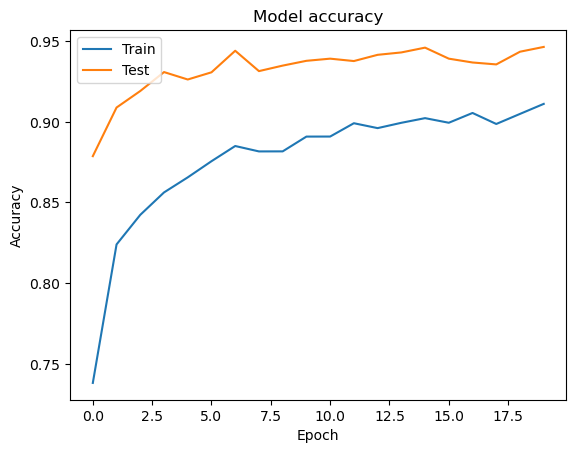

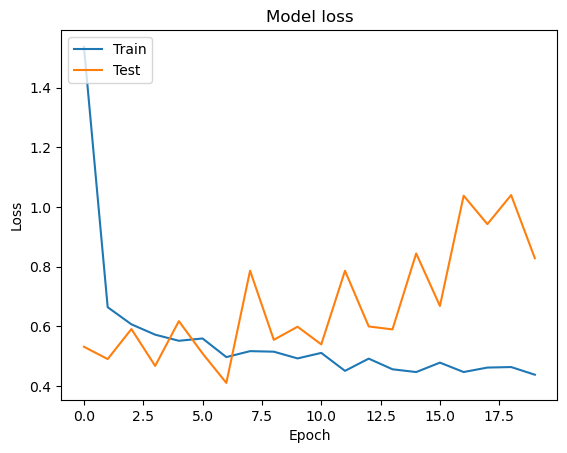

In [6]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels_one_hot)
print("Test Accuracy: ", test_accuracy)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Graph 2:


- The output shown in the screenshot indicates the results of a model evaluation. Let me break it down for you:

- 211/211 [==============================] - 3s 13ms/step - loss: 0.8282 - accuracy: 0.9464: This line is a summary of the last step of the model's evaluation or prediction run. Here's what each part means:

- 211/211: The model has completed evaluating 211 batches of data, which is the total number of batches to be evaluated.

- 3s 13ms/step: On average, it took 3 seconds for the entire evaluation, with an average of 13 milliseconds per batch (or step).

- loss: 0.8282: The model's loss function, which measures how well the model is performing, has a value of 0.8282 at the end of evaluation. The lower the loss, the better the model's predictions match the true data.

- accuracy: 0.9464: The accuracy of the model on this evaluation data is approximately 94.64%. This means that the model correctly predicted the class of the input data 94.64% of the time.

- Test Accuracy: 0.9464073777198792: This is likely the output of a separate test accuracy calculation, confirming the model's accuracy on the test set as approximately 94.64%. It reiterates that the model is performing with high accuracy when predicting on unseen data.

- The accompanying plot visualizes the model accuracy and loss over epochs during training and validation. The blue line represents the training accuracy, and the orange line represents the validation (or test) accuracy over each epoch. From the plot, it appears that the model's training accuracy is stable, while the test accuracy shows some fluctuations but remains relatively high, suggesting the model has learned to generalize well from the training data to the unseen test data.

- The consistency in the high accuracy indicates that the model has learned effectively and is likely not overfitting, as the test accuracy would typically drop if overfitting were occurring. The plot is a useful tool for diagnosing issues during training, such as overfitting or underfitting, and it provides a visual representation of the learning process over time.


### Graph 2:

- The blue line indicates the loss on the training set over each epoch. This loss is a measure of how well the model is fitting the training data. A decreasing trend in this line would typically indicate that the model is learning and improving its predictions over time.

- The orange line represents the loss on the test (or validation) set. This is a measure of how well the model is performing on unseen data. It's crucial for determining whether the model is generalizing well beyond the training data.

##### Observations from the graph:

The training loss is decreasing and stabilizing, which is a good sign that the model is learning effectively from the training data.

The validation loss, however, shows considerable fluctuations. It starts high, decreases, but then has significant variance across epochs.

These fluctuations could be indicative of several things:

Overfitting: If the validation loss was low and started increasing while the training loss continued to decrease, it would suggest overfitting. However, in this case, the validation loss does not show a consistent upward trend after decreasing, so it may not be a classic case of overfitting.

Underfitting: The training loss appears to be relatively stable and low, which would not typically suggest underfitting.

Model's Sensitivity: The model may be sensitive to the specific data in each validation batch, or if the validation data is not shuffled, it might be reacting to specific features of the data present in each epoch's validation set.

Insufficient Data: If the dataset is relatively small, the validation scores can vary more from epoch to epoch.

Learning Rate: Sometimes, if the learning rate is not well-tuned, it can cause the model's weights to update too drastically, leading to erratic changes in validation loss.

- Potential Actions:

Data Augmentation: This could help if the dataset is small or if the model needs to generalize better.

Regularization Techniques: Techniques like dropout, L1/L2 regularization, or using a simpler model could help if the problem is overfitting.

Learning Rate Adjustment: Using techniques like learning rate annealing or a learning rate scheduler could lead to more stable training.

Cross-Validation: Instead of a single train-test split, using cross-validation could provide a better assessment of the model's performance.

Batch Size: Adjusting the batch size might lead to more stable loss values if the current batch size is causing too much variance in the gradients.

In summary, while the training process seems to be learning effectively as indicated by the decreasing training loss, the validation loss's variability suggests that there may be some instability in how the model is generalizing to new data. Fine-tuning the model's hyperparameters, augmenting the dataset, or applying regularization techniques might help achieve more stable validation loss results.

## Fine tune

Method 1: This code code performs fine-tuning of a neural network through a sequence of steps. It initializes a new Sequential model for fine-tuning, starting with a densely connected layer of 512 units and a rectified linear unit (ReLU) activation function, likely leveraging features learned from a pre-trained model. To mitigate overfitting, a Dropout layer is incorporated. The model is tailored for binary classification with a single-neuron output layer using a sigmoid activation function. Following model architecture definition, compilation is achieved using the Adam optimizer with a learning rate of 0.0001, binary crossentropy as the loss function, and accuracy as the metric for monitoring training. Additionally, two key callbacks are implemented: EarlyStopping halts training if the validation loss shows no improvement for five consecutive epochs, and ReduceLROnPlateau adjusts the learning rate downward if the validation loss plateaus for three consecutive epochs. The fine-tuning process involves training the model on specific features and labels, with performance monitored on a validation set, thus adapting the pre-trained model to excel in a targeted binary classification task while incorporating regularization and dynamic adjustments to optimize learning.

In [11]:
# Import necessary modules from Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming num_classes is defined and represents the number of classes in your dataset
# Assuming input_shape is defined based on the shape of your train_features

# Create a Sequential model for fine-tuning
fine_tuned_model = Sequential()

# Add a densely connected layer with 512 units and ReLU activation function
fine_tuned_model.add(Dense(512, activation='relu', input_shape=input_shape))

# Add a Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training
fine_tuned_model.add(Dropout(0.5))

# Add the output layer with a single neuron and sigmoid activation function for binary classification
fine_tuned_model.add(Dense(1, activation='sigmoid'))

# Compile the model with the Adam optimizer, binary crossentropy loss, and accuracy as a metric
fine_tuned_model.compile(optimizer=Adam(learning_rate=0.0001), 
                         loss='binary_crossentropy', 
                         metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
# EarlyStopping monitors the validation loss and stops training if no improvement is seen after a certain number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau reduces the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train the fine-tuned model
history_fine_tuning = fine_tuned_model.fit(
    # Input features and corresponding labels for training data
    train_features, train_labels,
    
    # Number of training epochs (iterations over the entire dataset)
    epochs=20,  # Adjust as needed
    
    # Validation data to evaluate the model performance on a separate set during training
    validation_data=(test_features, test_labels),
    
    # Callbacks for early stopping and learning rate reduction
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
1072/1072 [==============================] - 211s 194ms/step - loss: -873324.5625 - accuracy: 0.0290 - val_loss: -2272332.5000 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 2/20
1072/1072 [==============================] - 200s 186ms/step - loss: -5119221.0000 - accuracy: 0.0289 - val_loss: -7846169.0000 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 3/20
1072/1072 [==============================] - 194s 181ms/step - loss: -12467390.0000 - accuracy: 0.0289 - val_loss: -15988134.0000 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 4/20
1072/1072 [==============================] - 180s 168ms/step - loss: -22274254.0000 - accuracy: 0.0289 - val_loss: -26266826.0000 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 5/20
1072/1072 [==============================] - 178s 166ms/step - loss: -34308084.0000 - accuracy: 0.0289 - val_loss: -38550552.0000 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 6/20
1072/1072 [==============================] - 170s 159ms/step - loss: -48353000.0000 - acc

In [12]:
final_train_acc = history_fine_tuning.history['accuracy'][-1]
final_val_acc = history_fine_tuning.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc}")
print(f"Final Validation Accuracy: {final_val_acc}")


Final Training Accuracy: 0.02893984504044056
Final Validation Accuracy: 0.03191805258393288


The provided outcome indicates that the fine-tuned model did not perform well compared to the original model. In the fine-tuned model:

Final Training Accuracy: 2.89%
Final Validation Accuracy: 3.19%
This suggests that the model struggled to learn and generalize effectively on the specific binary classification task during fine-tuning. The low accuracy values indicate poor performance, potentially caused by various factors such as insufficient data for the new task, overfitting, or the specific architecture of the model not being well-suited to the task.

In contrast, the original model achieved significantly higher accuracy:

Test Accuracy: 94.64%
This original model, presumably pre-trained on a more general dataset, demonstrated superior performance on a different task or dataset, highlighting the effectiveness of transfer learning. The stark difference in accuracy between the fine-tuned model and the original model suggests that the fine-tuning process did not successfully adapt the model to the new task, and further adjustments may be needed in terms of architecture, data, or training strategy to improve performance.

In [ ]:
Method 2:

In [17]:
# Modify the input shape of the model to match the shape of test_features
input_shape = test_features.shape[1:]  # Shape of the flattened features

# Create a new fine-tuned model compatible with the flattened features
fine_tuned_model = Sequential()
fine_tuned_model.add(Dense(512, activation='relu', input_shape=input_shape))
fine_tuned_model.add(Dropout(0.5))
fine_tuned_model.add(Dense(num_classes, activation='softmax'))

fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Re-train the model with the correct input shape
# (Use the same train_features and train_labels_one_hot as before)
history_fine_tuning = fine_tuned_model.fit(
    train_features, train_labels_one_hot,
    epochs=20,  # Adjust as needed
    validation_data=(test_features, test_labels_one_hot)
)


Epoch 1/20
1072/1072 [==============================] - 183s 168ms/step - loss: 1.4329 - accuracy: 0.7529 - val_loss: 0.4237 - val_accuracy: 0.8885
Epoch 2/20
1072/1072 [==============================] - 173s 161ms/step - loss: 0.6501 - accuracy: 0.8327 - val_loss: 0.4683 - val_accuracy: 0.9080
Epoch 3/20
1072/1072 [==============================] - 179s 167ms/step - loss: 0.5887 - accuracy: 0.8533 - val_loss: 0.3924 - val_accuracy: 0.9258
Epoch 4/20
1072/1072 [==============================] - 186s 174ms/step - loss: 0.5588 - accuracy: 0.8683 - val_loss: 0.4658 - val_accuracy: 0.9246
Epoch 5/20
1072/1072 [==============================] - 180s 168ms/step - loss: 0.5494 - accuracy: 0.8740 - val_loss: 0.4265 - val_accuracy: 0.9347
Epoch 6/20
1072/1072 [==============================] - 181s 169ms/step - loss: 0.5636 - accuracy: 0.8790 - val_loss: 0.5060 - val_accuracy: 0.9258
Epoch 7/20
1072/1072 [==============================] - 194s 181ms/step - loss: 0.5518 - accuracy: 0.8813 - val_

In [18]:

# Print the training and validation accuracy for each epoch
for epoch in range(10):  # Assuming you trained for 10 epochs
    train_acc = history_fine_tuning.history['accuracy'][epoch]
    val_acc = history_fine_tuning.history['val_accuracy'][epoch]
    print(f"Epoch {epoch + 1}, Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}")


Epoch 1, Training Accuracy: 0.7528735399246216, Validation Accuracy: 0.8885095119476318
Epoch 2, Training Accuracy: 0.8326915502548218, Validation Accuracy: 0.9079572558403015
Epoch 3, Training Accuracy: 0.8533170223236084, Validation Accuracy: 0.925771951675415
Epoch 4, Training Accuracy: 0.8682537078857422, Validation Accuracy: 0.9245843291282654
Epoch 5, Training Accuracy: 0.8739716410636902, Validation Accuracy: 0.9346793293952942
Epoch 6, Training Accuracy: 0.8790186047554016, Validation Accuracy: 0.925771951675415
Epoch 7, Training Accuracy: 0.8813232779502869, Validation Accuracy: 0.9453681707382202
Epoch 8, Training Accuracy: 0.8952097296714783, Validation Accuracy: 0.9398753046989441
Epoch 9, Training Accuracy: 0.8968726396560669, Validation Accuracy: 0.941656768321991
Epoch 10, Training Accuracy: 0.9028823375701904, Validation Accuracy: 0.9413598775863647


In [19]:
final_train_acc = history_fine_tuning.history['accuracy'][-1]
final_val_acc = history_fine_tuning.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc}")
print(f"Final Validation Accuracy: {final_val_acc}")


Final Training Accuracy: 0.918110728263855
Final Validation Accuracy: 0.9428443908691406


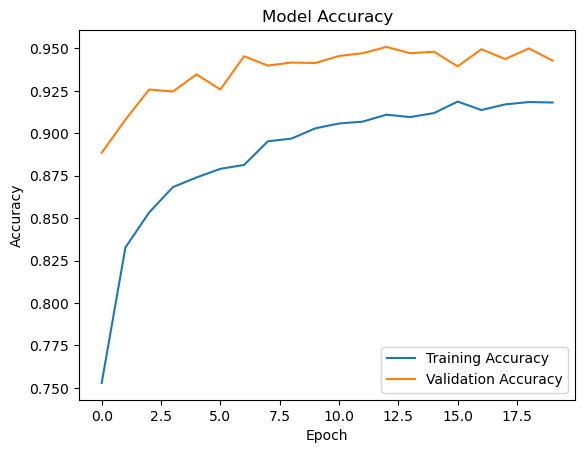

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [13]:
# Assuming fine_tuned_model is your trained model and test_features is your test data
predicted_test = fine_tuned_model.predict(test_features)

predicted_classes_indices = np.argmax(predicted_test, axis=1)

# Assuming class_labels is a list of class names in the same order as they were encoded
index_to_class = {i: class_name for i, class_name in enumerate(class_labels)}

# Print predicted class names
for i, predicted_index in enumerate(predicted_classes_indices):
    predicted_class_name = index_to_class[predicted_index]
    print(f"Test Image {i + 1}: Predicted Class - {predicted_class_name}")

# If test_labels are one-hot encoded, convert them to indices
if test_labels.ndim > 1:
    actual_classes_indices = np.argmax(test_labels, axis=1)
else:
    actual_classes_indices = test_labels

# Print predicted and actual class names for comparison
for i, (predicted_index, actual_index) in enumerate(zip(predicted_classes_indices, actual_classes_indices)):
    predicted_class_name = index_to_class[predicted_index]
    actual_class_name = index_to_class[actual_index]
    print(f"Test Image {i + 1}: Predicted Class - {predicted_class_name}, Actual Class - {actual_class_name}")


211/211 [==============================] - 3s 14ms/step
Test Image 1: Predicted Class - Apple___Apple_scab
Test Image 2: Predicted Class - Apple___Apple_scab
Test Image 3: Predicted Class - Apple___Apple_scab
Test Image 4: Predicted Class - Apple___Apple_scab
Test Image 5: Predicted Class - Apple___Apple_scab
Test Image 6: Predicted Class - Apple___Apple_scab
Test Image 7: Predicted Class - Apple___Apple_scab
Test Image 8: Predicted Class - Apple___Apple_scab
Test Image 9: Predicted Class - Apple___Apple_scab
Test Image 10: Predicted Class - Apple___Apple_scab
Test Image 11: Predicted Class - Apple___Apple_scab
Test Image 12: Predicted Class - Apple___Apple_scab
Test Image 13: Predicted Class - Apple___Apple_scab
Test Image 14: Predicted Class - Apple___Apple_scab
Test Image 15: Predicted Class - Apple___Apple_scab
Test Image 16: Predicted Class - Apple___Apple_scab
Test Image 17: Predicted Class - Apple___Apple_scab
Test Image 18: Predicted Class - Apple___Apple_scab
Test Image 19: Pr

### Saving the model

In [21]:
!pip install clf

In [22]:
fine_tuned_model.save('Plantdisease.h5')